# Libraries

In [1]:
import qutip as qt

import cvxpy as cp
import numpy as np
import itertools


import matplotlib.pyplot as plt




In [2]:
((1-0.75)*0.75) + (0.75 * (np.cos(np.pi/8)**2))

0.8276650429449552

In [3]:
((1-0.75)*  (np.cos(np.pi/8)**2)) + (0.75 * 0.75)

0.7758883476483185

## Partial Trace for cvxpy

In [2]:
##
##https://github.com/cvxgrp/cvxpy/issues/563

import numpy as np
import cvxpy
from cvxpy.expressions.expression import Expression


def expr_as_np_array(cvx_expr):
    if cvx_expr.is_scalar():
        return np.array(cvx_expr)
    elif len(cvx_expr.shape) == 1:
        return np.array([v for v in cvx_expr])
    else:
        # then cvx_expr is a 2d array
        rows = []
        for i in range(cvx_expr.shape[0]):
            row = [cvx_expr[i,j] for j in range(cvx_expr.shape[1])]
            rows.append(row)
        arr = np.array(rows)
        return arr


def np_array_as_expr(np_arr):
    aslist = np_arr.tolist()
    expr = cvxpy.bmat(aslist)
    return expr


def np_partial_trace(rho, dims, axis=0):
    """
    Takes partial trace over the subsystem defined by 'axis'
    rho: a matrix
    dims: a list containing the dimension of each subsystem
    axis: the index of the subsytem to be traced out
    (We assume that each subsystem is square)
    """
    dims_ = np.array(dims)
    # Reshape the matrix into a tensor with the following shape:
    # [dim_0, dim_1, ..., dim_n, dim_0, dim_1, ..., dim_n]
    # Each subsystem gets one index for its row and another one for its column
    reshaped_rho = np.reshape(rho, np.concatenate((dims_, dims_), axis=None))

    # Move the subsystems to be traced towards the end
    reshaped_rho = np.moveaxis(reshaped_rho, axis, -1)
    reshaped_rho = np.moveaxis(reshaped_rho, len(dims)+axis-1, -1)

    # Trace over the very last row and column indices
    traced_out_rho = np.trace(reshaped_rho, axis1=-2, axis2=-1)

    # traced_out_rho is still in the shape of a tensor
    # Reshape back to a matrix
    dims_untraced = np.delete(dims_, axis)
    rho_dim = np.prod(dims_untraced)
    return traced_out_rho.reshape([rho_dim, rho_dim])


def partial_trace(rho, dims, axis=0,debug=False):
    if not isinstance(rho, Expression):
        rho = cvxpy.Constant(shape=rho.shape, value=rho)
    rho_np = expr_as_np_array(rho)
    traced_rho = np_partial_trace(rho_np, dims, axis)
    if(debug):
        print("this is what numpy said")
        print(traced_rho)
        for row in traced_rho:
            for element in row:
                print(element)
    ##########                
    #traced_rho = np_array_as_expr(traced_rho)
    ####################
    # if(debug):
    #     print("this is what the expression became")
    #     print(traced_rho)
    return traced_rho



## Tensor product with cvxpy

In [3]:
def general_kron(a, b):
    """
    Returns a CVXPY Expression representing the Kronecker product of a and b.
    
    At most one of "a" and "b" may be CVXPY Variable objects.
    
    :param a: 2D numpy ndarray, or a CVXPY Variable with a.ndim == 2
    :param b: 2D numpy ndarray, or a CVXPY Variable with b.ndim == 2
    """
    expr = np.kron(a, b)
    num_rows = expr.shape[0]
    rows = [cvxpy.hstack(expr[i,:]) for i in range(num_rows)]
    full_expr = cvxpy.vstack(rows)
    return full_expr

# QuTiP | Encoding the problem

In [4]:
verbose=True
#fileName = "cache_temp_1"

## Building Block

### Bare Kets

In [5]:
o=qt.basis(2,0)
l=qt.basis(2,1)


I=qt.identity(2)

ι = 0+1j

TP = qt.tensor

def D(obj):
    return obj.dag()

### The unitary and the projector

#### Projectors for measurement etc

In [6]:
Π_z0 = o * D(o)
Π_z1 = l * D(l)
display(Π_z0,Π_z1)
    
x0 = (o + l)/np.sqrt(2)
x1 = (o - l)/np.sqrt(2)


Π_x0 = x0 * D(x0)
Π_x1 = x1 * D(x1)
display(Π_x0,Π_x1)


y0 = (o + ι*l)/np.sqrt(2)
y1 = (o - ι*l)/np.sqrt(2)


Π_y0 = y0 * D(y0)
Π_y1 = y1 * D(y1)
display(Π_y0,Π_y1)



def Π_z(i):
    if i==0:
        return Π_z0
    else:
        return Π_z1

def Π_y(i):
    if i==0:
        return Π_y0
    else:
        return Π_y1

def Π_x(i):
    if i==0:
        return Π_x0
    else:
        return Π_x1

X_hat = o * D(l) + l *D(o)
display(X_hat)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5 -0.5]
 [-0.5  0.5]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

### Projector from functions | projForFunc(f,c)

In [7]:
def projForFunc(f,c):
    #f is the function
    #c is the parameter count
    
    bi = [0,1]
    
    Π = None
    
    for var in itertools.product(bi,repeat=c):
        if(f(*var)):
            _ = TP(*[Π_z(b) for b in var])
            
            if Π is None:
                Π = _
            else:
                Π += _
                
    
    return Π


# the generalised implementation above is based on the following

# bi = [0,1]

# #To evaluate S (=S')
# U_s = None
# def f(a,x,r):
#     return (a+(x*r))%2

# for a,x,r in itertools.product(bi,bi,bi):        
#     if (f(a,x,r)):
#         #HXA RS
#         _ = TP(I,Π_z(x),Π_z(a),Π_z(r),X_hat)
#         # _ = TP(I,Π_z(x),Π_z(a),Π_z(r),X_hat,X_hat)

    #     if U_s is None:
    #         U_s = _
    #     else:
    #         U_s += _
    

## \[P\] Alice Self-tests | Cheat vectors for Bob

In this setting, Alice performs an extra test (ET) and she performs a rigidity test of the boxs before initiating the protocol.

In [8]:
#HXARS
σ0 = TP( 0.5 * I, x0*D(x0), o*D(o), x0*D(x0), o*D(o) )
# σ0 = TP( 0.5 * I, x0*D(x0), o*D(o), x0*D(x0), o*D(o), o*D(o) )

#Simulates the mesaurement of H
#control is on X
#measured system is H
#outcome is stored in A
#Acts on
#HXA RS

# U_ghz = TP(Π_x0,Π_z0,I, I,I,I) + \
#     TP(Π_x1,Π_z0,X_hat, I,I,I) + \
#     TP(Π_y0,Π_z1,I, I,I,I) + \
#     TP(Π_y1,Π_z1,X_hat, I,I,I)

U_ghz = TP(Π_x0,Π_z0,I, I,I) + \
    TP(Π_x1,Π_z0,X_hat, I,I) + \
    TP(Π_y0,Π_z1,I, I,I) + \
    TP(Π_y1,Π_z1,X_hat, I,I)



σ1 = U_ghz * σ0 * D(U_ghz)

bi = [0,1]

#To evaluate S (=S')
U_s = None
def f(a,x,r):
    return (a+(x*r))%2

for a,x,r in itertools.product(bi,bi,bi):        
    if (f(a,x,r)):
        #HXA RS
        _ = TP(I,Π_z(x),Π_z(a),Π_z(r),X_hat)
        # _ = TP(I,Π_z(x),Π_z(a),Π_z(r),X_hat,X_hat)
    else:
        _ = TP(I,Π_z(x),Π_z(a),Π_z(r),I)
        # _ = TP(I,Π_z(x),Π_z(a),Π_z(r),I,I)

    if U_s is None:
        U_s = _
    else:
        U_s += _


σ2 = U_s * σ1 * D(U_s)

#HXAR(S)
ρ = (σ2).ptrace([0,1,2,3])
# #HXARS(S)
# ρ = (σ2).ptrace([0,1,2,3,4])

print(ρ.tr())
display(ρ)




# ####################Constructing the projector



Π = None
_ = None

#GHZ winning condition
# def f(x,y, b,c, r,s,g):
#     if( (x+g)%2 == 1 and (s+(x*r)+b+c+1)%2 == x*y*((1+x+y)%2) ):
#     # Sanity check; do I recover 0.75? It failed; TODO: revisit
#     # if( (x+g)%2 == 1 ):
#         return 1
#     else:
#         return 0

def f(x,a,g,y,d):
    if( (x+g)%2 == 1 and (a+d)%2 == (((x*y*((x+y+1)%2))%2 +1)%2) ):
        return 1
    else:
        return 0    


for x, a, g, y, d in itertools.product(bi, bi,bi,bi, bi):        
    if (f(x, a, g,y, d)==1):
        
        #HXA RGYD
        _ = TP(I,Π_z(x),Π_z(a),I,Π_z(g),Π_z(y),Π_z(d))
        if Π is None:
            Π = _
        else:
            Π += _

display(Π)

####################
#Π_abort

Π_abort = None
_ = None

def f_ab(x,a,g,y,d):
    if( (x+g)%2 == 1 and (a+d)%2 != (((x*y*((x+y+1)%2))%2 +1)%2) ):
        return 1
    else:
        return 0    


for x, a, g, y, d in itertools.product(bi,bi,bi, bi,bi):        
    if (f_ab(x, a, g,y, d)==1):
        
        #HXA RGYD
        _ = TP(I,Π_z(x),Π_z(a),I,Π_z(g),Π_z(y),Π_z(d))
        if Π_abort is None:
            Π_abort = _
        else:
            Π_abort += _

display(Π_abort)






#AA'XRSG
Π_ = None
_ = None

Π__ = None
__ = None
#GHZ winning condition
def f(x,g):
    # if( (x+g)%2 == 1 and (s+(x*r)+b+c+1)%2 == x*y*((1+x+y)%2) ):
    # Sanity check; do I recover 0.75?
    # if( (x+g)%2 == 1 ):
    if( (x+g)%2 == 1 ):
        return 1
    else:
        return 0

for x,g in itertools.product(bi,bi):        
    if (f(x,g)==1):
        #print(a,b,c, x,y,z, g, f(a,b,c,x,y,z,g))
        #TODO
        
        #HXA RGYD
        _ = TP(I,Π_z(x),I,I,Π_z(g),I,I)
        #HXARG
        __ = TP(I,Π_z(x),I,I,Π_z(g))
        #_ = TP(I,Π_z(x),Π_z(a),Π_z(r),Π_z(g),Π_z(y),Π_z(d))
        
        #XRSGYBC
        #_ = TP(I,I,Π_z(x),Π_z(r),Π_z(s),Π_z(g))
        if Π_ is None:
            Π_ = _
            Π__ = __
            # print("calculated the symbolic part, working on the representation")
            # Π_ = rep(_)
            # print("completed the representation")
        else:
            Π_ += _
            Π__ += __
            # Π_ = rep(_)


display(Π_)



# Π = None
# _ = None
# #GHZ winning condition
# def f(a,b,c,x,y,z,g):
#     if( (x+g)%2 == 1 and (a+b+c+1)%2 == (x*y*z)):
#         return 1
#     else:
#         return 0    
# Π_ = None
# #I_ = Π_z0 + Π_z1

# for a,b,c, x,y,z, g in itertools.product(bi,bi,bi, bi,bi,bi, bi):        
#     if (f(a,b,c, x,y,z, g)==1):
#         #print(a,b,c, x,y,z, g, f(a,b,c,x,y,z,g))
#         _ = TP(I,        #A(BC)
#             Π_z(x), Π_z(y),Π_z(z),   #X(YZ) YZ  
#             Π_z(a),I,I,Π_z(g),Π_z(b),Π_z(c)) #A(S)SRGBC

#         if Π is None:
#             Π = _
#             # print("calculated the symbolic part, working on the representation")
#             # Π_ = rep(_)
#             # print("completed the representation")
#         else:
#             Π += _
#             # Π_ = rep(_)


# print("Constructed the projector")            
# if(verbose): 
#     display(Π)
#     # display(Π_)
#     #display(sq.represent(Π))
#     #display(rep(Π))

# #     dill.dump([U,U_I,U_II,Π], open(fileName, "wb"))
# #     print("Saved to disk")


0.9999999999999996


Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.0625 +0.j       0.0625 +0.j       0.     +0.j       0.     +0.j
   0.03125+0.03125j  0.     +0.j       0.     +0.j       0.03125-0.03125j
   0.0625 +0.j       0.0625 +0.j       0.     +0.j       0.     +0.j
   0.03125-0.03125j  0.     +0.j       0.     +0.j       0.03125+0.03125j]
 [ 0.0625 +0.j       0.0625 +0.j       0.     +0.j       0.     +0.j
   0.03125+0.03125j  0.     +0.j       0.     +0.j       0.03125-0.03125j
   0.0625 +0.j       0.0625 +0.j       0.     +0.j       0.     +0.j
   0.03125-0.03125j  0.     +0.j       0.     +0.j       0.03125+0.03125j]
 [ 0.     +0.j       0.     +0.j       0.0625 +0.j       0.0625 +0.j
   0.     +0.j       0.03125-0.03125j  0.03125+0.03125j  0.     +0.j
   0.     +0.j       0.     +0.j      -0.0625 +0.j      -0.0625 +0.j
   0.     +0.j      -0.03125-0.03125j -0.03125+0.03125j  0.     +0.j     ]
 [ 0.     +0.j       0.     +0.j  

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]], shape = (128, 128), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]], shape = (128, 128), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]], shape = (128, 128), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

### Sanity test for the projectors

In [ ]:
np.allclose(Π*Π,Π, rtol=1e-05, atol=1e-08, equal_nan=False)

bigEye=TP(I,I,I,I,I,I,I)

np.allclose(Π+Π_abort,bigEye,rtol=1e-05, atol=1e-08, equal_nan=False)

In [ ]:
Π + Π_abort

## \[Q\] Bob Self-tests | Cheat Vectors for Alice

In this setting, Bob performs the usual protocol but he performs the rigidity test before initiating the protocol. The hope is that the cheat vector would yield something worthwhile.

In [11]:
# ρ0 = tr_A(|GHZ⟩⟨GHZ|_ABC) = (|00⟩⟨00| + |11⟩⟨11|)/2
# BC

ρ0 = 0.5 * (TP(Π_z0,Π_z0) + TP(Π_z1,Π_z1))

# The projector outputting Alice won and the GHZ test passes
# Π_α := Π_0 * Π_GHZ_passed
# It acts on ρ2∈ Pos(BC SG XA)
# 64 x 64

# Π_consistency ≐  s is a ⊕ x.r ⇔ if x=0, then s=a.
# Π_0 ≐ x⊕g is 0
# Π_GHZ ≐ 
#          if x=0, then with equal probability, use y=0,z=1 and y=1,z=0; 
#                 and check if a⊕b⊕c = 1
#          if x=1, then with equal probability, use y=0,z=0 and y=1,z=1;
#                 with check if a⊕b⊕c = 1 and a⊕b⊕b = 0, respectively
#  in effect, this means [*]
#          if x=0 then measure with equal probability...

# Recall: The GHZ test requires the inputs to satisfy x⊕y⊕z=1 and 
#         the output to satisfy a⊕b⊕c = xyz⊕1

def f_consistency(b,c, s,g, x,a):
    if (x==0 and s!=a):
        return 0
    else:
        return 1
    
Π_consistency = projForFunc(f_consistency,6)

def f_0(b,c, s,g, x,a):
    if((x+g)%2 == 0):
        return 1
    else:
        return 0
    
Π_0 = projForFunc(f_0,6)


def f_1(b,c, s,g, x,a):
    if((x+g)%2 == 1):
        return 1
    else:
        return 0
    
Π_1 = projForFunc(f_1,6)


# Now the dreaded Π_GHZ
Π_GHZ_A = None
Π_GHZ_B = None
bi = [0,1]

#Π_GHZ_A corresponds to the success cases given either x=0, y=0, z=1 or x=1, y=0, z=0
#Π_GHZ_B corresponds to the success cases given either x=0, y=1, z=0 or x=1, y=1, z=1
#Each of the four choices of x,y,z are chosen uniformly at random
#Once x is fixed, Bob chooses the pair (y,z) with equal probability; 
#so he chooses Π_GHZ_A and Π_GHZ_B with equal probabilities which automatically condition on x
#Why I split it this way, is because x=0 and x=1 are two distinct possibilities and 
#then the choices of y,z may correspond to non-commuting measurements (wrt to the choices of y and z)

for b,c, x,a in itertools.product(bi,repeat=4):    
    # x = 0 (measure a along x)
    _A = None
    _B = None
    if(x==0):
                
        if( ((a+b+c)%2) == 1):
            # y = 0 (measure b along x), z = 1 (measure c along y)
            _A =  TP(Π_x(b),Π_y(c), I,I, Π_z(x),Π_z(a))
            # z = 0 (measure c along x), y = 1 (measure b along y)
            _B =  TP(Π_y(b),Π_x(c), I,I, Π_z(x),Π_z(a))
            
    else: #i.e. x==1
        # y=0, z=0 (measure b and c along x) and check a⊕b⊕c=1
        if( ((a+b+c)%2)== 1 ):
            _A = TP(Π_x(b), Π_x(c), I,I, Π_z(x),Π_z(a))
            
        # y=1, z=1 (measure b and c along y) and check a⊕b⊕c=0  
        else:    #i.e. (a+b+c)%1)==0
            _B = TP(Π_y(b), Π_y(c), I,I, Π_z(x),Π_z(a))
            
    
    if _A is not None:
        if Π_GHZ_A is None:
            Π_GHZ_A = _A           
        else:
            Π_GHZ_A += _A

    if _B is not None:
        if Π_GHZ_B is None:
            Π_GHZ_B = _B           
        else:
            Π_GHZ_B += _B

Π_pseudo_GHZ = 0.5*(Π_GHZ_A + Π_GHZ_B)


### Sanity checks

In [ ]:
Π_GHZ_A

In [ ]:
#Π_GHZ * Π_GHZ - Π_GHZ
print("Projectors really projectors?")
print(isProj(Π_0),isProj(Π_consistency),isProj(Π_GHZ_A),isProj(Π_GHZ_B))

In [ ]:
def isProj(Π):
    return np.allclose(Π*Π, Π)

In [ ]:
#testProj = TP(Π_x(1),Π_y(1), I,I, Π_z(1),Π_x(1)) + TP(Π_x(0),Π_y(1), I,I, Π_z(1),Π_x(1))

testProj = TP(Π_x(0)) #+ TP(Π_x(0))

print(isProj( testProj ))
      
#A=np.zeros(3)

#Π_0
display(testProj)
display(testProj*testProj - testProj)

In [ ]:
A=np.array([[1,1],[1,1]])*0.5
display(A)

In [ ]:
display(A@A)

### Debug

In [ ]:
bi=[0,1]

for A in itertools.product(bi,repeat=3):
    print (A)

In [ ]:
A[0]=5
A[0]

In [ ]:
def f(a,b,c):
    return a+b+c

In [ ]:

f(*A)

In [ ]:
TP(*[Π_z(x) for x in A])

In [ ]:
projForFunc(f,3)

In [ ]:
#HXARS
σ0 = TP( 0.5 * I, x0*D(x0), o*D(o), x0*D(x0), o*D(o) )
# σ0 = TP( 0.5 * I, x0*D(x0), o*D(o), x0*D(x0), o*D(o), o*D(o) )

#Simulates the mesaurement of H
#control is on X
#measured system is H
#outcome is stored in A
#Acts on
#HXA RS

# U_ghz = TP(Π_x0,Π_z0,I, I,I,I) + \
#     TP(Π_x1,Π_z0,X_hat, I,I,I) + \
#     TP(Π_y0,Π_z1,I, I,I,I) + \
#     TP(Π_y1,Π_z1,X_hat, I,I,I)

U_ghz = TP(Π_x0,Π_z0,I, I,I) + \
    TP(Π_x1,Π_z0,X_hat, I,I) + \
    TP(Π_y0,Π_z1,I, I,I) + \
    TP(Π_y1,Π_z1,X_hat, I,I)



σ1 = U_ghz * σ0 * D(U_ghz)

bi = [0,1]

#To evaluate S (=S')
U_s = None
def f(a,x,r):
    return (a+(x*r))%2

for a,x,r in itertools.product(bi,bi,bi):        
    if (f(a,x,r)):
        #HXA RS
        _ = TP(I,Π_z(x),Π_z(a),Π_z(r),X_hat)
        # _ = TP(I,Π_z(x),Π_z(a),Π_z(r),X_hat,X_hat)
    else:
        _ = TP(I,Π_z(x),Π_z(a),Π_z(r),I)
        # _ = TP(I,Π_z(x),Π_z(a),Π_z(r),I,I)

    if U_s is None:
        U_s = _
    else:
        U_s += _


σ2 = U_s * σ1 * D(U_s)

#HXAR(S)
ρ = (σ2).ptrace([0,1,2,3])
# #HXARS(S)
# ρ = (σ2).ptrace([0,1,2,3,4])

print(ρ.tr())
display(ρ)




# ####################Constructing the projector



Π = None
_ = None

#GHZ winning condition
# def f(x,y, b,c, r,s,g):
#     if( (x+g)%2 == 1 and (s+(x*r)+b+c+1)%2 == x*y*((1+x+y)%2) ):
#     # Sanity check; do I recover 0.75? It failed; TODO: revisit
#     # if( (x+g)%2 == 1 ):
#         return 1
#     else:
#         return 0

def f(x,a,g,y,d):
    if( (x+g)%2 == 1 and (a+d)%2 == (((x*y*((x+y+1)%2))%2 +1)%2) ):
        return 1
    else:
        return 0    


for x, a, g, y, d in itertools.product(bi, bi,bi,bi, bi):        
    if (f(x, a, g,y, d)==1):
        
        #HXA RGYD
        _ = TP(I,Π_z(x),Π_z(a),I,Π_z(g),Π_z(y),Π_z(d))
        if Π is None:
            Π = _
        else:
            Π += _

display(Π)

####################
#Π_abort

Π_abort = None
_ = None

def f_ab(x,a,g,y,d):
    if( (x+g)%2 == 1 and (a+d)%2 != (((x*y*((x+y+1)%2))%2 +1)%2) ):
        return 1
    else:
        return 0    


for x, a, g, y, d in itertools.product(bi,bi,bi, bi,bi):        
    if (f_ab(x, a, g,y, d)==1):
        
        #HXA RGYD
        _ = TP(I,Π_z(x),Π_z(a),I,Π_z(g),Π_z(y),Π_z(d))
        if Π_abort is None:
            Π_abort = _
        else:
            Π_abort += _

display(Π_abort)






#AA'XRSG
Π_ = None
_ = None

Π__ = None
__ = None
#GHZ winning condition
def f(x,g):
    # if( (x+g)%2 == 1 and (s+(x*r)+b+c+1)%2 == x*y*((1+x+y)%2) ):
    # Sanity check; do I recover 0.75?
    # if( (x+g)%2 == 1 ):
    if( (x+g)%2 == 1 ):
        return 1
    else:
        return 0

for x,g in itertools.product(bi,bi):        
    if (f(x,g)==1):
        #print(a,b,c, x,y,z, g, f(a,b,c,x,y,z,g))
        #TODO
        
        #HXA RGYD
        _ = TP(I,Π_z(x),I,I,Π_z(g),I,I)
        #HXARG
        __ = TP(I,Π_z(x),I,I,Π_z(g))
        #_ = TP(I,Π_z(x),Π_z(a),Π_z(r),Π_z(g),Π_z(y),Π_z(d))
        
        #XRSGYBC
        #_ = TP(I,I,Π_z(x),Π_z(r),Π_z(s),Π_z(g))
        if Π_ is None:
            Π_ = _
            Π__ = __
            # print("calculated the symbolic part, working on the representation")
            # Π_ = rep(_)
            # print("completed the representation")
        else:
            Π_ += _
            Π__ += __
            # Π_ = rep(_)


display(Π_)



# Π = None
# _ = None
# #GHZ winning condition
# def f(a,b,c,x,y,z,g):
#     if( (x+g)%2 == 1 and (a+b+c+1)%2 == (x*y*z)):
#         return 1
#     else:
#         return 0    
# Π_ = None
# #I_ = Π_z0 + Π_z1

# for a,b,c, x,y,z, g in itertools.product(bi,bi,bi, bi,bi,bi, bi):        
#     if (f(a,b,c, x,y,z, g)==1):
#         #print(a,b,c, x,y,z, g, f(a,b,c,x,y,z,g))
#         _ = TP(I,        #A(BC)
#             Π_z(x), Π_z(y),Π_z(z),   #X(YZ) YZ  
#             Π_z(a),I,I,Π_z(g),Π_z(b),Π_z(c)) #A(S)SRGBC

#         if Π is None:
#             Π = _
#             # print("calculated the symbolic part, working on the representation")
#             # Π_ = rep(_)
#             # print("completed the representation")
#         else:
#             Π += _
#             # Π_ = rep(_)


# print("Constructed the projector")            
# if(verbose): 
#     display(Π)
#     # display(Π_)
#     #display(sq.represent(Π))
#     #display(rep(Π))

# #     dill.dump([U,U_I,U_II,Π], open(fileName, "wb"))
# #     print("Saved to disk")


# cvxpy | The SDP itself

## \[P\] Alice Self-tests | Cheat vectors for Bob

### Setting up the cvxpy problem

In [9]:
#should ideally be hermitian
#Jamie uses HXRAGYD
#I use HXARGYD


#HXARGYD
ρ2 = cp.Variable((2**7,2**7), hermitian=True)

#HXARG
ρ1 = cp.Variable((2**5,2**5),hermitian=True)


#constraints += [cp.trace(σ1)==1,cp.trace(σ2)==1]


#The non-trivial constraints

#So what I've done here is the following
#When converting back from numpy, it was using Vstac and Hstac
#This seemed to make everything inefficient
#So now, I just return the numpy expression for partial_trace
#and then to trace again, I use the numpy expression

trG_ρ1 = partial_trace(ρ1,[2]*5,4) #HXAR(G)

trD_ρ2 = partial_trace(ρ2,[2]*7,6) #HXARGY(D)
trYD_ρ2 = np_partial_trace(trD_ρ2,[2]*6,5) #HXARG(Y)

#trBC_ρ2 = np_partial_trace(trC_ρ2,[2]*8,7) #AA'XRSGY(B)


# trB_σ2=partial_trace(σ2,[2]*10,8) #trace out C'; AXYZASR(B)CG
# # trBC_σ2=np_array_as_expr(np_partial_trace(trB_σ2,[2]*9,8)) #trace out C'; AXYZASR(C)G
# trBC_σ2=np_partial_trace(trB_σ2,[2]*9,8) #trace out C'; AXYZASR(C)G

# trG_σ1=partial_trace(σ1,[2]*10,9) #trace out G; AXYZYZASR(G)

# trY_σ1=partial_trace(σ1,[2]*10,2) #trace out Y; AX(Y)ZYZASRG
# # trYZ_σ1=np_array_as_expr(np_partial_trace(trY_σ1,[2]*9,2)) #trace out Z; AX(Z)YZASRG
# trYZ_σ1=np_partial_trace(trY_σ1,[2]*9,2) #trace out Z; AX(Z)YZASRG

In [ ]:
print(trD_ρ2[0,0])

In [ ]:
ρ1[0,0]

In [ ]:
general_kron(ρ1,np.eye(2))[0,0]

In [ ]:
ρ1_Y = np.kron(expr_as_np_array(ρ1),np.eye(2)/2.0)

In [ ]:
ρ1_Y[0,0]

In [10]:
#constraints = [σ1>>0] #[σ1>>0, σ2>>0]
constraints = [ρ1>>0, ρ2>>0]

#Just to test, I am using the numpy expression
#And adding the condition for each element
#cvxpy wasn't accepting these numpy matrices directly

#print(trYZ_σ1[0,0])
#HXARG Y
#ρ1_Y = general_kron(ρ1,np.eye(2)/2.0)
#ρ1_Y = general_kron(np.eye(2)/2.0,ρ1)


ρ1_Y = np.kron(expr_as_np_array(ρ1),np.eye(2)/2.0)


print("Working")

#HXARGY
n=len(trD_ρ2) #int(len(trBC_ρ2)/(2**0))

for i in range(n):
    print(i,end='\r')
    for j in range(int(n)):
        constraints += [trD_ρ2[i,j] == ρ1_Y[i,j]] #np.eye(n)[i,j]] #ρ1_Y[i,j]] #np.kron(ρ1,np.eye(2)/2.0)[i,j]]
print(n)
print("completed 1 of 2")

#######################

#Testing if a bigger trace works

# #HXARGY
# n=len(trYD_ρ2) #int(len(trBC_ρ2)/(2**0))

# for i in range(n):
#     print(i,end='\r')
#     for j in range(int(n)):
#         constraints += [trYD_ρ2[i,j] == ρ1[i,j]] #np.eye(n)[i,j]] #ρ1_Y[i,j]] #np.kron(ρ1,np.eye(2)/2.0)[i,j]]
# print(n)
# print("completed 1 of 2")

# ###############################


#HXAR
n=len(trG_ρ1) # int(len(trG_ρ1)/(2**0))
print("Working")
for i in range(n):
    print(i,end='\r')
    for j in range(n): #range(int(len(trG_σ1)/2)):
        constraints += [trG_ρ1[i,j] == ρ[i,j]]
print(n)
print("completed 2 of 2")




print(constraints[4])

# constraints += [trG_σ1 == trS_Uρ1U.data, trBC_σ2 == trYZ_σ1 ]

#constraints += [ cp.trace(σ1) == cp.trace(trS_Uρ1U),cp.trace(σ2)==cp.trace(σ1) ]


Working
64
completed 1 of 2
Working
16
completed 2 of 2
var0[0, 4] + var0[1, 5] == var1[0, 1] @ 0.5


In [ ]:
#trG_σ1
#trS_Uρ1U.data
#print(trBC_σ2[0,0])

In [ ]:
#trYZ_σ1[1,1]

### Creating the graph for the cheat vector

WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column pointers) not strictly increasing, column 8514 empty
WARN: A->p (column pointers) not strictly increasing, column 8643 empty
WARN: A->p (column pointers) not strictly increasing, column 8772 empty
WARN: A->p (column pointers) not strictly increasing, column 8901 empty
WARN: A->p (column pointers) not strictly increasing, column 9030 empty
WARN: A->p (column pointers) not strictly increasing, column 9159 empty
WARN: A->p (column pointers) not strictly increasing, column 9288 empty
WARN: A->p (column pointers) not strictly increasing, column 9417 empty
WARN: A->p (column pointers) not strictly increasing, column 9546 empty
WARN: A->p (column pointers) not strictly increasing, column 9675 empty
WARN: A->p (column pointers) not strictly increasing, column 9804 empty
WARN: A->p (column pointers) not strictly increasing, column 993

    40| 4.69e-06  2.81e-05  1.37e-05  8.79e-06  2.25e-05  2.41e-16  1.24e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.24e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 1.12e-03s
	Cones: avg projection time: 2.29e-02s
	Acceleration: avg step time: 3.82e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7941e-09, dist(y, K*) = 2.0195e-09, s'y/|s||y| = -1.9959e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.6948e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.8057e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.3716e-05
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column pointers) not strictly increasing, column 8514 empty
WARN: A

   100| 4.07e-04  1.36e-03  1.83e-05  2.15e-05  3.27e-06  2.64e-16  3.28e+00 
   200| 3.45e-05  1.34e-04  3.70e-05  6.11e-05  2.41e-05  2.70e-17  6.95e+00 
   240| 2.25e-05  7.97e-05  4.63e-06  9.18e-05  9.65e-05  1.23e-16  8.37e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.38e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 1.04e-03s
	Cones: avg projection time: 2.69e-02s
	Acceleration: avg step time: 4.35e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7480e-09, dist(y, K*) = 2.2871e-09, s'y/|s||y| = -3.0372e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.2549e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.9682e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.6329e-06
----------------------------------------------------------------------------
c'x = 0.0001, -b'y = 0.0001
WARN: A->p (column pointers) not strictly increasing, column 8256 e

   100| 1.92e-04  8.16e-04  1.01e-04  2.26e-04  1.25e-04  2.38e-16  3.32e+00 
   200| 9.30e-05  3.17e-04  2.63e-06  3.70e-04  3.72e-04  3.01e-17  6.75e+00 
   240| 6.93e-06  2.14e-05  5.35e-06  3.76e-04  3.81e-04  2.48e-16  8.19e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.19e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.42e-04s
	Cones: avg projection time: 2.69e-02s
	Acceleration: avg step time: 3.95e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.6246e-09, dist(y, K*) = 5.3193e-09, s'y/|s||y| = 3.0085e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.9286e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.1415e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.3528e-06
----------------------------------------------------------------------------
c'x = 0.0004, -b'y = 0.0004
WARN: A->p (column pointers) not strictly increasing, column 8256 em

   100| 1.01e-04  5.15e-04  2.24e-04  9.97e-04  1.22e-03  2.20e-16  3.21e+00 
   180| 2.26e-05  7.65e-05  1.40e-05  8.81e-04  8.95e-04  4.54e-16  5.93e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.93e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 1.01e-03s
	Cones: avg projection time: 2.56e-02s
	Acceleration: avg step time: 3.93e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.6807e-09, dist(y, K*) = 1.6782e-09, s'y/|s||y| = 1.0054e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.2637e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.6518e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.4025e-05
----------------------------------------------------------------------------
c'x = 0.0009, -b'y = 0.0009
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WA

   100| 1.79e-03  8.02e-03  1.69e-04  2.13e-03  1.96e-03  2.18e-16  3.01e+00 
   200| 5.67e-04  1.99e-03  6.98e-05  1.57e-03  1.64e-03  5.85e-17  6.27e+00 
   260| 9.18e-06  2.81e-05  1.92e-05  1.60e-03  1.62e-03  1.55e-16  8.45e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.45e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 8.74e-04s
	Cones: avg projection time: 2.52e-02s
	Acceleration: avg step time: 4.15e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.6115e-09, dist(y, K*) = 2.1815e-09, s'y/|s||y| = -4.9577e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.1774e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.8130e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.9206e-05
----------------------------------------------------------------------------
c'x = 0.0016, -b'y = 0.0016
WARN: A->p (column pointers) not strictly increasing, column 8256 e

   100| 1.20e-04  5.19e-04  5.51e-05  2.52e-03  2.46e-03  2.22e-16  3.23e+00 
   200| 8.79e-05  2.45e-04  6.66e-05  2.68e-03  2.75e-03  2.69e-17  6.69e+00 
   260| 2.46e-05  8.45e-05  8.84e-06  2.62e-03  2.62e-03  1.33e-16  8.83e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.83e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 8.85e-04s
	Cones: avg projection time: 2.69e-02s
	Acceleration: avg step time: 3.89e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1133e-09, dist(y, K*) = 2.1518e-09, s'y/|s||y| = 1.1811e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4606e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.4522e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.8439e-06
----------------------------------------------------------------------------
c'x = 0.0026, -b'y = 0.0026
WARN: A->p (column pointers) not strictly increasing, column 8256 em

   100| 2.06e+20  4.81e+20  1.11e-01 -1.66e+18 -2.07e+18  7.60e+20  3.07e+00 
   200| 6.38e-05  2.00e-04  4.88e-05  4.11e-03  4.16e-03  2.27e-18  6.33e+00 
   300| 9.11e-05  2.84e-04  5.18e-05  4.21e-03  4.15e-03  3.76e-16  9.85e+00 
   400| 2.15e-05  5.99e-05  6.38e-06  4.15e-03  4.16e-03  1.13e-16  1.35e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.35e+01s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.06e-04s
	Cones: avg projection time: 2.65e-02s
	Acceleration: avg step time: 3.93e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7818e-09, dist(y, K*) = 2.4063e-09, s'y/|s||y| = -6.0367e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.1490e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.9912e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.3784e-06
----------------------------------------------------------------------------
c'x = 0.0041, -b'

   100| 6.01e-04  1.98e-03  6.77e-06  5.40e-03  5.41e-03  4.07e-17  3.12e+00 
   200| 9.69e-04  3.27e-03  5.07e-05  5.85e-03  5.90e-03  4.40e-17  6.50e+00 
   220| 1.02e-05  2.92e-05  1.52e-05  6.03e-03  6.04e-03  3.63e-16  7.22e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.22e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.42e-04s
	Cones: avg projection time: 2.53e-02s
	Acceleration: avg step time: 4.20e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0350e-09, dist(y, K*) = 2.2274e-09, s'y/|s||y| = -6.2635e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0166e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.9220e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.5172e-05
----------------------------------------------------------------------------
c'x = 0.0060, -b'y = 0.0060
WARN: A->p (column pointers) not strictly increasing, column 8256 e

   100| 1.03e-04  3.13e-04  2.64e-04  8.10e-03  8.37e-03  3.04e-16  3.21e+00 
   180| 4.37e-05  9.09e-05  6.13e-06  8.46e-03  8.45e-03  3.22e-16  5.85e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.85e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.07e-04s
	Cones: avg projection time: 2.55e-02s
	Acceleration: avg step time: 3.72e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3848e-09, dist(y, K*) = 9.4969e-09, s'y/|s||y| = 1.1812e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.3688e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.0916e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.1292e-06
----------------------------------------------------------------------------
c'x = 0.0085, -b'y = 0.0085
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WA

   100| 6.32e-04  2.36e-03  5.04e-04  1.16e-02  1.10e-02  2.84e-17  3.18e+00 
   200| 2.22e-04  8.08e-04  9.27e-05  1.15e-02  1.16e-02  3.29e-16  6.60e+00 
   240| 2.57e-05  6.94e-05  6.44e-05  1.18e-02  1.17e-02  1.19e-16  8.06e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.06e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.94e-04s
	Cones: avg projection time: 2.56e-02s
	Acceleration: avg step time: 4.64e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3537e-09, dist(y, K*) = 2.1905e-09, s'y/|s||y| = -1.3006e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.5700e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.9439e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.4359e-05
----------------------------------------------------------------------------
c'x = 0.0118, -b'y = 0.0117
WARN: A->p (column pointers) not strictly increasing, column 8256 e

   100| 1.01e-03  3.80e-03  5.13e-06  1.64e-02  1.64e-02  1.16e-16  3.11e+00 
   200| 3.61e-05  1.29e-04  1.57e-05  1.59e-02  1.59e-02  3.66e-16  6.46e+00 
   300| 1.86e-04  5.67e-04  4.33e-04  1.59e-02  1.63e-02  1.56e-16  9.95e+00 
   360| 1.79e-05  6.09e-05  6.31e-06  1.63e-02  1.63e-02  1.35e-16  1.21e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.21e+01s
	Lin-sys: nnz in L factor: 166978, avg solve time: 8.76e-04s
	Cones: avg projection time: 2.65e-02s
	Acceleration: avg step time: 3.89e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2658e-09, dist(y, K*) = 2.4559e-09, s'y/|s||y| = -1.2440e-09
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.7893e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0948e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.3111e-06
----------------------------------------------------------------------------
c'x = 0.0163, -b'

   100| 2.85e-04  7.13e-04  7.38e-04  1.92e-02  2.00e-02  1.95e-16  3.22e+00 
   200| 1.74e-04  5.99e-04  3.88e-04  2.25e-02  2.29e-02  2.47e-16  6.50e+00 
   300| 7.54e-05  3.24e-04  1.03e-04  2.23e-02  2.22e-02  7.01e-17  9.92e+00 
   400| 2.95e+19  7.88e+19  1.97e-03 -1.04e+18 -1.04e+18  1.18e+20  1.34e+01 
   440| 1.81e-05  6.02e-05  2.48e-05  2.24e-02  2.24e-02  2.65e-16  1.48e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.48e+01s
	Lin-sys: nnz in L factor: 166978, avg solve time: 8.82e-04s
	Cones: avg projection time: 2.65e-02s
	Acceleration: avg step time: 3.93e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.9544e-09, dist(y, K*) = 1.5547e-09, s'y/|s||y| = -3.5006e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8110e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0171e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.4764e-05
----------------

   100| 1.42e+20  3.42e+20  1.84e-01 -6.24e+18 -9.06e+18  5.30e+20  3.09e+00 
   200| 5.17e+18  1.38e+19  1.81e-02 -1.82e+17 -1.89e+17  2.08e+19  6.39e+00 
   300| 1.29e-03  4.69e-03  1.18e-03  3.34e-02  3.46e-02  1.62e-16  9.85e+00 
   400| 1.80e-04  7.83e-04  8.31e-06  3.29e-02  3.29e-02  1.79e-16  1.34e+01 
   500| 1.47e-04  5.65e-04  1.29e-04  3.30e-02  3.32e-02  9.65e-17  1.68e+01 
   600| 6.65e-04  2.28e-03  7.12e-05  3.27e-02  3.26e-02  9.87e-17  2.04e+01 
   700| 9.76e-05  3.29e-04  1.85e-05  3.30e-02  3.30e-02  2.04e-16  2.40e+01 
   740| 1.95e-05  4.81e-05  6.36e-06  3.29e-02  3.29e-02  2.16e-16  2.54e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.54e+01s
	Lin-sys: nnz in L factor: 166978, avg solve time: 8.95e-04s
	Cones: avg projection time: 2.71e-02s
	Acceleration: avg step time: 4.05e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7668e-0

   100| 2.07e-03  6.86e-03  2.88e-03  4.81e-02  4.49e-02  2.08e-16  3.18e+00 
   200| 4.01e-02  1.15e-01  1.46e-01  4.52e-02 -1.25e-01  2.27e-16  6.60e+00 
   300| 9.73e-02  3.09e-01  2.25e-01  9.93e-02 -1.90e-01  1.39e-16  1.02e+01 
   400| 1.88e-02  5.18e-02  6.16e-02  6.12e-02  1.35e-01  2.19e-17  1.40e+01 
   443| 2.84e+10  6.16e+10  1.00e+00  5.03e+10  3.07e+16  3.07e+16  1.56e+01 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 1.56e+01s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.10e-04s
	Cones: avg projection time: 2.81e-02s
	Acceleration: avg step time: 3.96e-03s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.8740e-09
|A'y|_2 * |b|_2 = 1.1660e-05
b'y = -1.0000
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column

   100| 1.19e-02  3.86e-02  1.73e-02  4.18e-02  6.09e-02  2.90e-16  3.09e+00 
   131| 1.85e+10  4.81e+10  1.00e+00 -5.01e+10  1.06e+18  1.06e+18  4.11e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 4.11e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.12e-04s
	Cones: avg projection time: 2.39e-02s
	Acceleration: avg step time: 4.14e-03s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.6598e-09
|A'y|_2 * |b|_2 = 2.6725e-07
b'y = -1.0000
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column pointers) not strictly increasing, column 8514 empty
WARN: A->p (column pointers) not strictly increasing, column 8643 empty
WARN: A->p (column pointers) not strictly increasing, column 8772 empty
WARN: A->p (column pointers) not str

    94| 3.86e+10  1.09e+11  1.00e+00  4.41e+10  2.89e+18  2.89e+18  3.03e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 3.03e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 1.07e-03s
	Cones: avg projection time: 2.45e-02s
	Acceleration: avg step time: 3.93e-03s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.5605e-09
|A'y|_2 * |b|_2 = 2.2431e-07
b'y = -1.0000
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column pointers) not strictly increasing, column 8514 empty
WARN: A->p (column pointers) not strictly increasing, column 8643 empty
WARN: A->p (column pointers) not strictly increasing, column 8772 empty
WARN: A->p (column pointers) not strictly increasing, column 8901 empty
WARN: A->p (column pointers) not strictly 

    87| 3.76e+10  1.02e+11  1.00e+00 -4.48e+10  5.31e+18  5.31e+18  2.68e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 2.68e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.01e-04s
	Cones: avg projection time: 2.34e-02s
	Acceleration: avg step time: 3.94e-03s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 4.3100e-10
|A'y|_2 * |b|_2 = 1.1562e-07
b'y = -1.0000
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column pointers) not strictly increasing, column 8514 empty
WARN: A->p (column pointers) not strictly increasing, column 8643 empty
WARN: A->p (column pointers) not strictly increasing, column 8772 empty
WARN: A->p (column pointers) not strictly increasing, column 8901 empty
WARN: A->p (column pointers) not strictly 

    85| 4.26e+10  8.44e+10  1.00e+00 -4.67e+09  1.15e+19  1.15e+19  2.67e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 2.67e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 1.00e-03s
	Cones: avg projection time: 2.34e-02s
	Acceleration: avg step time: 4.29e-03s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.3355e-09
|A'y|_2 * |b|_2 = 4.5256e-08
b'y = -1.0000
WARN: A->p (column pointers) not strictly increasing, column 8256 empty
WARN: A->p (column pointers) not strictly increasing, column 8385 empty
WARN: A->p (column pointers) not strictly increasing, column 8514 empty
WARN: A->p (column pointers) not strictly increasing, column 8643 empty
WARN: A->p (column pointers) not strictly increasing, column 8772 empty
WARN: A->p (column pointers) not strictly increasing, column 8901 empty
WARN: A->p (column pointers) not strictly 

    71| 3.80e+10  9.25e+10  1.00e+00 -1.96e+10  1.60e+19  1.60e+19  2.16e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 2.16e+00s
	Lin-sys: nnz in L factor: 166978, avg solve time: 9.49e-04s
	Cones: avg projection time: 2.23e-02s
	Acceleration: avg step time: 4.59e-03s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 7.5074e-09
|A'y|_2 * |b|_2 = 3.6076e-08
b'y = -1.0000


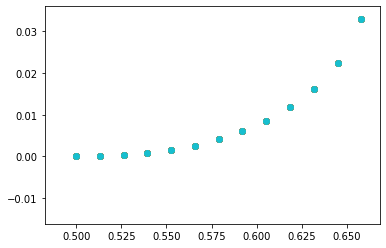

In [11]:
steps=20
f_α = []
α = []
for α_ in np.linspace(0.5,0.75,steps):
    prob = cp.Problem(cp.Minimize(cp.trace(cp.real(Π_abort.data @ ρ2  ))),constraints + [cp.trace(Π.data @ ρ2  ) == α_])
    prob.solve(solver=cp.SCS,verbose=True)
    f_α += [prob.value]
    α += [α_]
    plt.scatter(α,f_α)
    
α = np.linspace(0.5,0.75,steps)

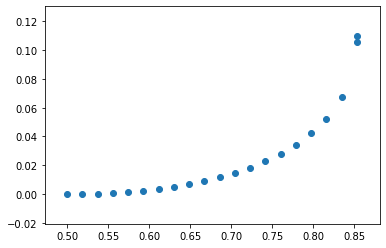

In [49]:
plt.scatter(α,f_α)

In [51]:
plt.savefig('AliceSelfTests_cheatVectors.svg')

<Figure size 432x288 with 0 Axes>

In [13]:
print(repr(α))

array([0.5       , 0.51315789, 0.52631579, 0.53947368, 0.55263158,
       0.56578947, 0.57894737, 0.59210526, 0.60526316, 0.61842105,
       0.63157895, 0.64473684, 0.65789474, 0.67105263, 0.68421053,
       0.69736842, 0.71052632, 0.72368421, 0.73684211, 0.75      ])


In [14]:
print(repr(f_α))

[8.791097074773234e-06, 9.18326670036261e-05, 0.0003757385715003838, 0.0008807580407079569, 0.0016038104340230005, 0.002624406349467629, 0.004149954525409667, 0.006029490958568537, 0.008457604058407564, 0.011785322282266126, 0.016260549348745903, 0.022416681827641588, 0.032938422457597975, inf, inf, inf, inf, inf, inf, inf]


In [ ]:
α=
[0.5       , 0.51315789, 0.52631579, 0.53947368, 0.55263158,
 0.56578947, 0.57894737, 0.59210526, 0.60526316, 0.61842105,
       0.63157895, 0.64473684, 0.65789474, 0.67105263, 0.68421053,
       0.69736842, 0.71052632, 0.72368421, 0.73684211, 0.75      ]

f_α =
[8.791097074773234e-06, 9.18326670036261e-05, 0.0003757385715003838, 0.0008807580407079569, 0.0016038104340230005, 0.002624406349467629, 0.004149954525409667, 0.006029490958568537, 0.008457604058407564, 0.011785322282266126, 0.016260549348745903, 0.022416681827641588, 0.032938422457597975, inf, inf, inf, inf, inf, inf, inf]

In [ ]:
(np.cos(np.pi/8.0)**2)*(2.0/3)

In [ ]:
1/2

In [ ]:
plt.scatter(α,f_α)

In [ ]:
#res = []

prob = cp.Problem(cp.Minimize(cp.trace(cp.real(Π_abort.data @ ρ2 ))),constraints + [cp.trace(Π.data @ ρ2 ) == 0.5])
prob.solve(solver=cp.SCS,verbose=True)


In [ ]:
prob = cp.Problem(cp.Minimize(cp.trace(cp.real(Π_abort.data @ ρ2 ))),constraints + [cp.trace(Π.data @ ρ2 ) == 0.74])
prob.solve(solver=cp.SCS,verbose=True)

In [ ]:
prob = cp.Problem(cp.Maximize(cp.trace(cp.real(Π.data @ ρ2 ))),constraints)
#prob = cp.Problem(cp.Maximize(cp.trace(cp.real(Π_.data @ ρ1 ))),constraints)

prob.solve(solver=cp.SCS,verbose=True) #,max_iters=10000) #MOSEK or SCS


### Repeated (Standard) Composition

In [20]:
#For recursive composition

def P_A(α,β):
    return α**2 + (1-α)*β

def P_B(α,β):
    return β*α + (1-β)*β

In [19]:
#For a tree like composition

def P_A_(α,β,p=np.cos(np.pi/8)**2,q=0.75):
    return p*α + (1-p)*β

def P_B_(α,β,p=np.cos(np.pi/8)**2,q=0.75):
    return q*α + (1-q)*β

In [17]:
point=np.cos(np.pi/8)**2
six=0.6670941202587581

In [21]:
α=point
β=six
for i in range(10):
    α_=P_A(α,β)
    β_=P_B(α,β)
    α=α_
    β=β_
    print(α,β)

0.8262470626603318 0.7914800031666518
0.8202061839506419 0.8189974355248048
0.819988858458517 0.8199873973857601
0.8199885954491422 0.8199885954470074
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578


In [26]:
#For the SCAKPM 11 article

print("Method 1")
α=np.cos(np.pi/8)**2 #0.854 #point
# β=3.0/4 #six
β=six

for i in range(10):
    α_=P_A(α,β)
    β_=P_B(α,β)
    α=α_
    β=β_
    print(α,β)


print("Method 2")
    
α=np.cos(np.pi/8)**2 #0.854 #point
# β=3.0/4 #six
β=six

for i in range(10):
    α_=P_A_(α,β)
    β_=P_B_(α,β)
    α=α_
    β=β_
    print(α,β)
    
    
print("Method 3 | autoAB")
    
α=np.cos(np.pi/8)**2 #0.854 #point
β=six #3.0/4 #six
# β=six #3.0/4 #six

for i in range(10):
    α_=P_A_(α,β,q=six)
    β_=P_B_(α,β,q=six)
    if(α_>β_):
        α=α_
        β=β_
    else:
        α=β_
        β=α_
    print(α_,β_)

Method 1
0.8262470626603318 0.7914800031666518
0.8202061839506419 0.8189974355248048
0.819988858458517 0.8199873973857601
0.8199885954491422 0.8199885954470074
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
0.8199885954487579 0.8199885954487578
Method 2
0.8262470626603318 0.8069385730096448
0.8234193998182238 0.8214199402476601
0.8231265857434689 0.8229195349255829
0.8230962638532145 0.8230748230389973
0.8230931239186695 0.8230909036496603
0.8230927987678012 0.8230925688514172
0.8230927650973263 0.8230927412887052
0.8230927616106345 0.8230927591451711
0.8230927612495758 0.8230927609942686
0.8230927612121869 0.823092761185749
Method 3 | autoAB
0.8262470626603318 0.7914800031666518
0.8211555446784404 0.8146729041335722
0.8202061839506419 0.8189974355248049
0.8200291668420524 0.8198037844925528
0.8199961603611481 0.819954135732714
0.819990005996802

In [42]:
#Sikora suppress once, standard composition after

#0.8276650429449552 0.8123171262343828

#0.8238280637673121 0.8200722724112737

α=0.8123 #np.cos(np.pi/8)**2 #0.854 #point
β=0.8276 #3.0/4 #six
for i in range(10):
    α_=P_A(α,β)
    β_=P_B(α,β)
    α=α_
    β=β_
    print(α,β)

0.81517181 0.8149377200000001
0.815128543569003 0.8151284887708748
0.8151285334383933 0.8151285334383902
0.8151285334383926 0.8151285334383926
0.8151285334383926 0.8151285334383926
0.8151285334383926 0.8151285334383926
0.8151285334383926 0.8151285334383926
0.8151285334383926 0.8151285334383926
0.8151285334383926 0.8151285334383926
0.8151285334383926 0.8151285334383926


#### Debug

In [ ]:
six

In [ ]:
point**2 + (1-point)*six

In [ ]:
(1-six)*six + six*(point)

In [ ]:
point_=P_A(point,six)

In [ ]:
six_=P_B(point,six)

In [ ]:
P_A(point_,six_)

In [ ]:
P_B(point_,six_)

In [35]:
0.37503721239695925*2

0.6750074424793918

### Outputs + debug

In [ ]:
# prob = cp.Problem(cp.Maximize(cp.trace(cp.real(Π.data @ ρ2 ))),constraints)
prob = cp.Problem(cp.Maximize(cp.trace(cp.real(Π_.data @ ρ2 ))),constraints)

prob.solve(solver=cp.SCS,verbose=True)#,max_iters=10000) #MOSEK or SCS


In [ ]:
prob = cp.Problem(cp.Maximize(cp.trace(cp.real(Π__.data @ ρ1 ))),constraints)

prob.solve(solver=cp.SCS,verbose=True)#,max_iters=10000) #MOSEK or SCS


## \[Q\] Bob Self-tests | Cheat vectors for Alice

### Setting up the cvxpy problem

In [12]:
#should ideally be hermitian


#BC SG XA
ρ2 = cp.Variable((2**6,2**6), hermitian=True)

#BCS
ρ1 = cp.Variable((2**3,2**3),hermitian=True)


#constraints += [cp.trace(σ1)==1,cp.trace(σ2)==1]


#The non-trivial constraints

#So what I've done here is the following
#When converting back from numpy, it was using Vstac and Hstac
#This seemed to make everything inefficient
#So now, I just return the numpy expression for partial_trace
#and then to trace again, I use the numpy expression

trS_ρ1 = partial_trace(ρ1,[2]*3,2) #BC(S)

trA_ρ2 = partial_trace(ρ2,[2]*6,5) #BC SG X(A)
trAX_ρ2 = np_partial_trace(trA_ρ2,[2]*5,4) #BC SG (X)


In [13]:
#constraints = [σ1>>0] #[σ1>>0, σ2>>0]
constraints = [ρ1>>0, ρ2>>0]

#Just to test, I am using the numpy expression
#And adding the condition for each element
#cvxpy wasn't accepting these numpy matrices directly

ρ1_G = np.kron(expr_as_np_array(ρ1),np.eye(2)/2.0)


print("Working")

#HXARGY
n=len(trAX_ρ2) #int(len(trBC_ρ2)/(2**0))

for i in range(n):
    print(i,end='\r')
    for j in range(int(n)):
        constraints += [trAX_ρ2[i,j] == ρ1_G[i,j]] #np.eye(n)[i,j]] #ρ1_Y[i,j]] #np.kron(ρ1,np.eye(2)/2.0)[i,j]]
print(n)
print("completed 1 of 2")

#######################

#Testing if a bigger trace works

# #HXARGY
# n=len(trYD_ρ2) #int(len(trBC_ρ2)/(2**0))

# for i in range(n):
#     print(i,end='\r')
#     for j in range(int(n)):
#         constraints += [trYD_ρ2[i,j] == ρ1[i,j]] #np.eye(n)[i,j]] #ρ1_Y[i,j]] #np.kron(ρ1,np.eye(2)/2.0)[i,j]]
# print(n)
# print("completed 1 of 2")

# ###############################


#HXAR
n=len(trS_ρ1) # int(len(trG_ρ1)/(2**0))
print("Working")
for i in range(n):
    print(i,end='\r')
    for j in range(n): #range(int(len(trG_σ1)/2)):
        constraints += [trS_ρ1[i,j] == ρ0[i,j]]
print(n)
print("completed 2 of 2")




print(constraints[4])

# constraints += [trG_σ1 == trS_Uρ1U.data, trBC_σ2 == trYZ_σ1 ]

#constraints += [ cp.trace(σ1) == cp.trace(trS_Uρ1U),cp.trace(σ2)==cp.trace(σ1) ]


Working
16
completed 1 of 2
Working
4
completed 2 of 2
var0[0, 8] + var0[1, 9] + var0[2, 10] + var0[3, 11] == var1[0, 1] @ 0.5


In [ ]:
isProj(Π_GHZ_A)

In [ ]:
isProj(Π_0)
isProj(Π_0*Π_consistency*Π_GHZ_A)

In [ ]:
Π_GHZ_A

In [ ]:
# prob = cp.Problem(cp.Maximize(cp.trace(cp.real(Π.data @ ρ2 ))),constraints)
# proj1 = Π_0 *Π_consistency * Π_GHZ_A

# proj2 = Π_0 * Π_consistency #* Π_GHZ_B

prob = cp.Problem(cp.Maximize(cp.trace(cp.real((Π_0*Π_consistency*Π_pseudo_GHZ).data @ ρ2 ))),constraints)


# prob = cp.Problem(cp.Maximize(cp.trace(cp.real( (proj1).data @ ρ2 @ (D(proj1)).data ))),constraints)
# prob = cp.Problem(cp.Maximize(cp.trace(cp.real( (proj1).data @ ρ2  ))),constraints)


# prob = cp.Problem(cp.Maximize(cp.trace(cp.real( 0.5 * (proj1).data @ ρ2 @ (D(proj1)).data + \
#                                                 0.5 * (proj2).data @ ρ2 @ (D(proj2)).data ))),constraints)

prob.solve(solver=cp.SCS,verbose=True)#,max_iters=10000) #MOSEK or SCS


In [59]:
np.cos(np.pi/8)**2

0.8535533905932737

### Single Composition | Bias

In [58]:
prob = cp.Problem(cp.Maximize(cp.trace( cp.real( ( ((np.cos(np.pi/8)**2) *Π_1 + 0.75*Π_0) * Π_consistency*Π_pseudo_GHZ).data  @ ρ2 ))),\
                  constraints )
prob.solve(solver=cp.SCS,verbose=True)


WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

0.8123171262343828

### Repeated Sikora Compression

<div>
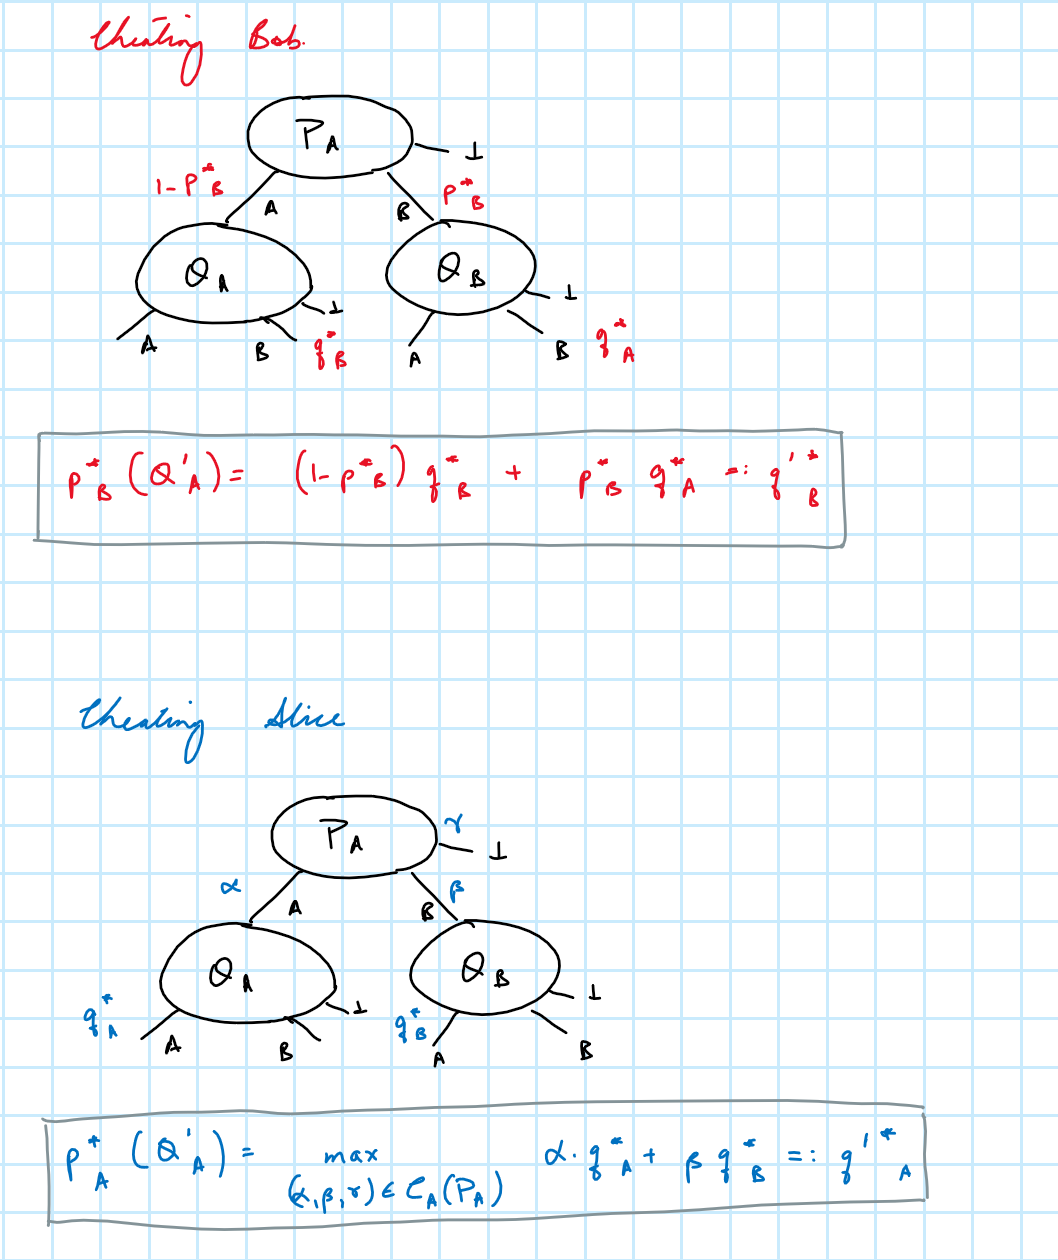
</div>

In [31]:
pA

0.8535533905932737

In [48]:
pB = 0.75
pA = np.cos(np.pi/8)**2

# pB = 0.6670941202587581
# pA = np.cos(np.pi/8)**2


def new_q_B(qA,qB):
    return ((1-pB) * qB) +  (pB*qA)
    
def new_q_A(qA,qB):
    # return pA*qA + (1-pA)*qB

    prob = cp.Problem(cp.Maximize(cp.trace( cp.real( ( (qA*Π_0 + qB*Π_1) * Π_consistency*Π_pseudo_GHZ).data  @ ρ2 ))),\
                      constraints )
    return prob.solve(solver=cp.SCS,verbose=False)



qA=pA
qB=pB
print(qA,qB)

for i in range(10):
    qA_=new_q_A(qA,qB)
    qB_=new_q_B(qA,qB)
    
    if(qA_>qB_):        
        qA=qA_
        qB=qB_
    else:
        print("flipped")
        qA=qB_
        qB=qA_
        
    print(qA_,qB_)
    
    
######################

#######Checking; debugging

# qA=pA
# qB=pB
# print(qA,qB)

# for i in range(20):
#     qA_=new_q_A(qA,qB)
#     qB_=new_q_B(qA,qB)
    
#     if(qA>qB):        ########## this should have been qA_>qB_;
#         qA=qA_
#         qB=qB_
#     else:
#         print("flipped")
#         qA=qB_
#         qB=qA_
        
#     print(qA_,qB_)
    
    
####################

0.8535533905932737 0.75
WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictl

flipped
0.8202679161558463 0.8238280637711263
WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column

flipped
0.8225308053037814 0.822719039292244
WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column 

flipped
0.8226474944315424 0.8226598463745656
WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column

flipped
0.8226550993805772 0.8226559667848987
WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column

flipped
0.8226555279042503 0.822655676785623


### Cheat Vector Graph

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

WARN: A->p (column pointers) not strictly increasing, column 2080 empty
WARN: A->p (column pointers) not strictly increasing, column 2145 empty
WARN: A->p (column pointers) not strictly increasing, column 2210 empty
WARN: A->p (column pointers) not strictly increasing, column 2275 empty
WARN: A->p (column pointers) not strictly increasing, column 2340 empty
WARN: A->p (column pointers) not strictly increasing, column 2405 empty
WARN: A->p (column pointers) not strictly increasing, column 2470 empty
WARN: A->p (column pointers) not strictly increasing, column 2535 empty
WARN: A->p (column pointers) not strictly increasing, column 2600 empty
WARN: A->p (column pointers) not strictly increasing, column 2665 empty
WARN: A->p (column pointers) not strictly increasing, column 2730 empty
WARN: A->p (column pointers) not strictly increasing, column 2795 empty
WARN: A->p (column pointers) not strictly increasing, column 2860 empty
WARN: A->p (column pointers) not strictly increasing, column 292

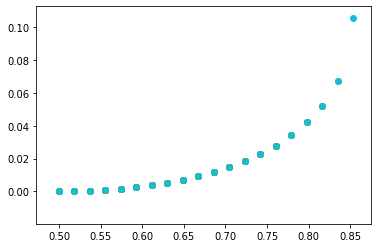

In [16]:
proj1 = Π_0*Π_consistency * Π_GHZ_A
proj2 = Π_0 * Π_consistency * Π_GHZ_B


proj1_ = Π_1*Π_consistency * Π_GHZ_A
proj2_ = Π_1*Π_consistency * Π_GHZ_B


# prob = cp.Problem(cp.Maximize(cp.trace(cp.real((Π_1*Π_consistency*Π_pseudo_GHZ).data @ ρ2 ))),constraints)
# prob = cp.Problem(cp.Maximize(cp.trace(cp.real( 0.5 * (proj1).data @ ρ2 @ (D(proj1)).data + \
#                                                 0.5 * (proj2).data @ ρ2 @ (D(proj2)).data ))),constraints)

steps=20
f_α = []
α = []
for α_ in np.linspace(0.5,0.8534,steps):
    
    prob = cp.Problem(cp.Maximize(cp.trace( cp.real( (Π_1*Π_consistency*Π_pseudo_GHZ).data @ ρ2 ))),\
                      constraints + [cp.trace( (Π_0*Π_consistency*Π_pseudo_GHZ).data @ ρ2) == α_] )
    prob.solve(solver=cp.SCS,verbose=False)
    
    f_α += [1-prob.value-α_]
    α   += [α_]
    plt.scatter(α,f_α)
    
α = np.linspace(0.5,0.8534,steps)

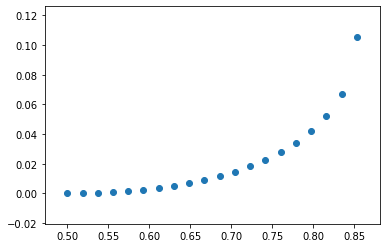

In [53]:
plt.scatter(α,f_α)

In [54]:
plt.savefig('BobSelfTests_cheatVectors.svg')

<Figure size 432x288 with 0 Axes>

In [18]:
print(α,f_α)

[0.5    0.5186 0.5372 0.5558 0.5744 0.593  0.6116 0.6302 0.6488 0.6674
 0.686  0.7046 0.7232 0.7418 0.7604 0.779  0.7976 0.8162 0.8348 0.8534] [-9.431424530248478e-09, 8.856745862129145e-05, 0.0003631528188815514, 0.0008379437366593523, 0.0015317089672823858, 0.0024627173481353015, 0.0036547708706534676, 0.005121872717691933, 0.006945270502823897, 0.0091078885643735, 0.011698733811661977, 0.014756159559157211, 0.018390185152519223, 0.022715445562739744, 0.027900505727182834, 0.03421765052210046, 0.042070954834185104, 0.052352916473586086, 0.06721194945026943, 0.10562462254053584]


In [32]:
print(repr(α))

array([0.5   , 0.5186, 0.5372, 0.5558, 0.5744, 0.593 , 0.6116, 0.6302,
       0.6488, 0.6674, 0.686 , 0.7046, 0.7232, 0.7418, 0.7604, 0.779 ,
       0.7976, 0.8162, 0.8348, 0.8534])


In [33]:
print(repr(f_α))

[-9.431424530248478e-09, 8.856745862129145e-05, 0.0003631528188815514, 0.0008379437366593523, 0.0015317089672823858, 0.0024627173481353015, 0.0036547708706534676, 0.005121872717691933, 0.006945270502823897, 0.0091078885643735, 0.011698733811661977, 0.014756159559157211, 0.018390185152519223, 0.022715445562739744, 0.027900505727182834, 0.03421765052210046, 0.042070954834185104, 0.052352916473586086, 0.06721194945026943, 0.10562462254053584]


In [52]:
#α vs f_a

α=[0.5   , 0.5186, 0.5372, 0.5558, 0.5744, 0.593 , 0.6116, 0.6302,
       0.6488, 0.6674, 0.686 , 0.7046, 0.7232, 0.7418, 0.7604, 0.779 ,
       0.7976, 0.8162, 0.8348, 0.8534]

f_α=[-9.431424530248478e-09, 8.856745862129145e-05, 0.0003631528188815514, 0.0008379437366593523, 0.0015317089672823858, 0.0024627173481353015, 0.0036547708706534676, 0.005121872717691933, 0.006945270502823897, 0.0091078885643735, 0.011698733811661977, 0.014756159559157211, 0.018390185152519223, 0.022715445562739744, 0.027900505727182834, 0.03421765052210046, 0.042070954834185104, 0.052352916473586086, 0.06721194945026943, 0.10562462254053584]

In [ ]:
print(f_α)

### Debug

In [ ]:
steps=10
f_α = []
α = []
for α_ in np.linspace(0.5,0.9,steps):
    
    prob = cp.Problem(cp.Maximize(cp.trace(cp.real((Π_1*Π_consistency*Π_pseudo_GHZ).data @ ρ2 ))),\
                      constraints + [cp.trace((Π_0*Π_consistency*Π_pseudo_GHZ).data @ ρ2 ) == α_])
    prob.solve(solver=cp.SCS,verbose=True)
    
    f_α += [1-prob.value-α_]
    α += [α_]
    plt.scatter(α,f_α)
    
α = np.linspace(0.5,0.9,steps)

In [ ]:
plt.scatter(α,f_α)

In [ ]:
np.cos(np.pi / 8.0)**2

# Temporary

In [ ]:
#Uttam Bhai's formula
#उत्तम भाई

for i in [True,False]:
    for j in [True,False]:
        for k in [True,False]:
            print ((i or (j and k)), ((i or j) and (i or k)))            